# Social network analysis and community detection in Twitter Data

#### Author : Kriti Upadhyaya

#### Description : 
The program implements Social Media Analysis and community detection in the twitter data. 

#### Program Dependencies
Following packages are required to be installed beofre running this program:
1. pymongo : To connect to dataset which is in MongoDb
2. networkx : Package to analyse network graphs, implements various community detection algorithm and evaluation metrics.
3. wordcloud : 
4. matplotlib
5. community

## Importing libraries

In [15]:
from pymongo import MongoClient
from collections import defaultdict, Counter
from operator import itemgetter
from networkx.algorithms import community
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from networkx.algorithms.community.centrality import girvan_newman
import pprint
import pymongo
import re
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mlt
import community
import numpy as np

## Collecting Tweet Data from MongoDB
Connection created for Mongodb and number of records printed.

In [16]:
client = MongoClient('mongodb://localhost:27017/termProject')
db = client.termProject
blackish = db.Blackish
gotham = db.Gotham
selfie = db.SelfieABC
red_band_society = db.RedBandSociety
ncis_nola = db.NCISNOLA
how_to_get_away = db.HowToGetAwayWithMurder

## Data Preprocessing
Deleting all the records from database where there is no user mention in the tweet. No user mention means that the tweet is not a retweet.

In [17]:
gotham.delete_many({'entities.user_mentions' : []})
blackish.delete_many({'entities.user_mention' : []})
selfie.delete_many({'entities.user_mentions' : []})
red_band_society.delete_many({'entities.user_mentions' : []})
ncis_nola.delete_many({'entities.user_mentions' : []})
how_to_get_away.delete_many({'entities.user_mentions' : []})
print('Total Record for the Gotham: ' + str(gotham.estimated_document_count()))
print('Total Record for the Blackish: ' + str(blackish.estimated_document_count()))
print('Total Record for the Selfie: ' + str(selfie.estimated_document_count()))
print('Total Record for the Red band society: ' + str(red_band_society.estimated_document_count()))
print('Total Record for the NCIS Nola: ' + str(ncis_nola.estimated_document_count()))
print('Total Record for the How to get away with murder: ' + str(how_to_get_away.estimated_document_count()))
data_source = [gotham, blackish, selfie, red_band_society, ncis_nola, how_to_get_away]

Total Record for the Gotham: 204530
Total Record for the Blackish: 69284
Total Record for the Selfie: 34248
Total Record for the Red band society: 89712
Total Record for the NCIS Nola: 12790
Total Record for the How to get away with murder: 101602


# Tweet Timeline
Creating timeline for blackish tweets

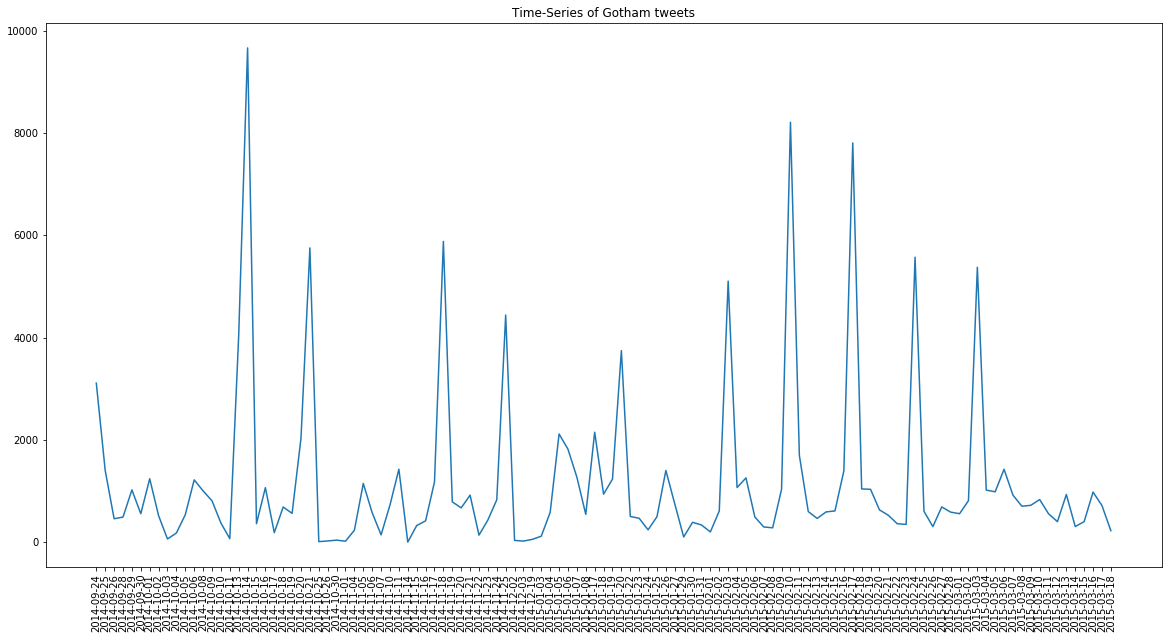

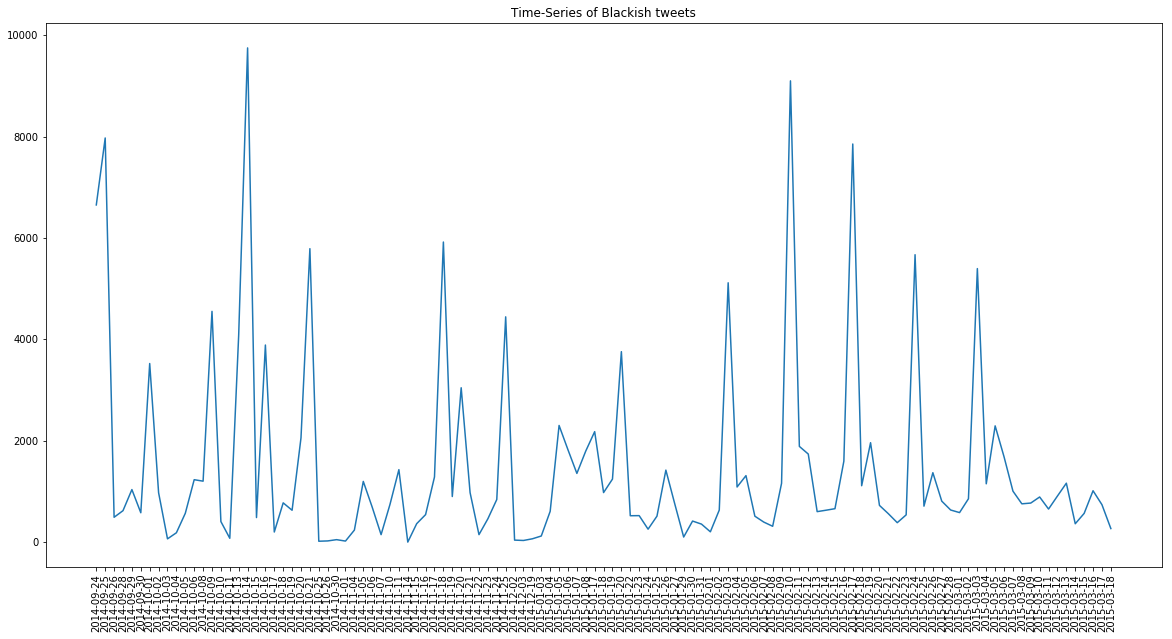

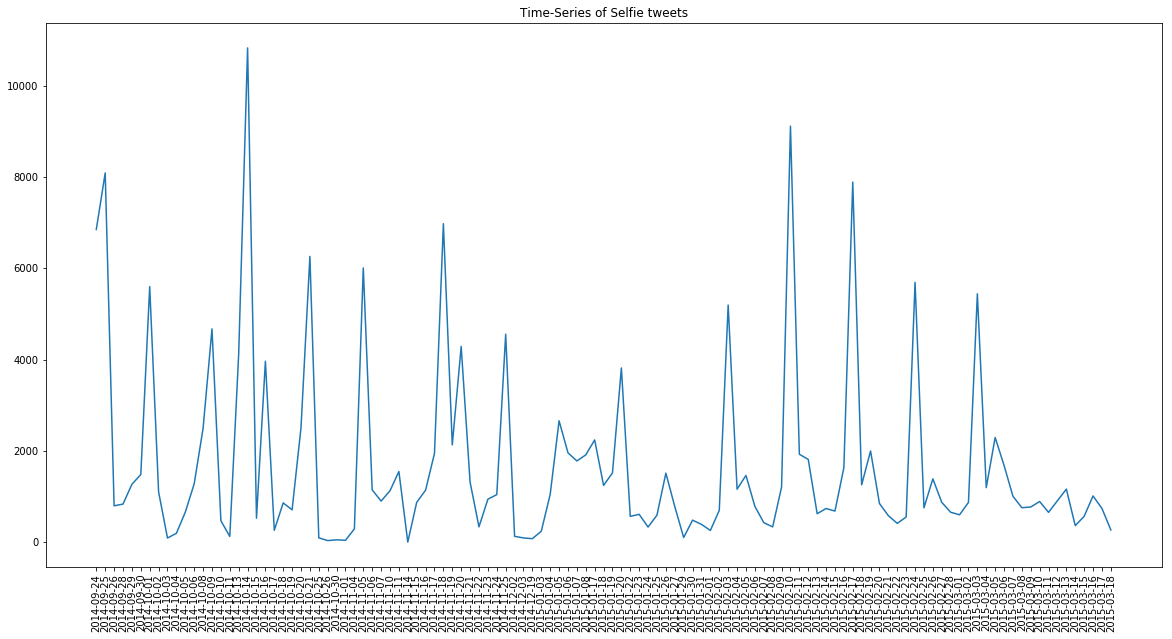

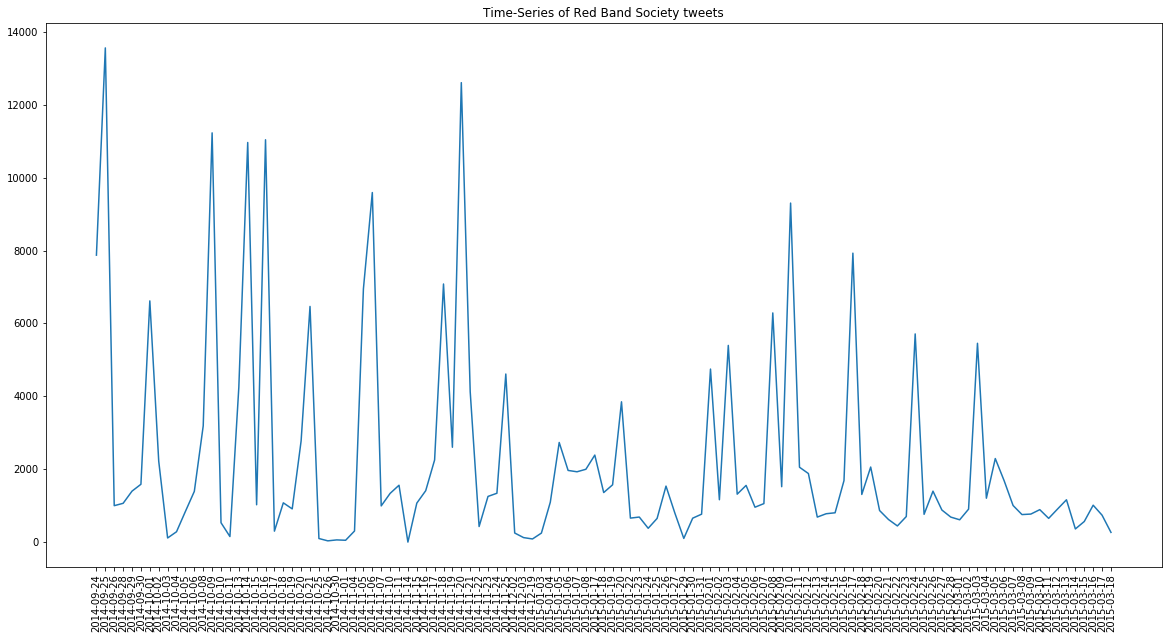

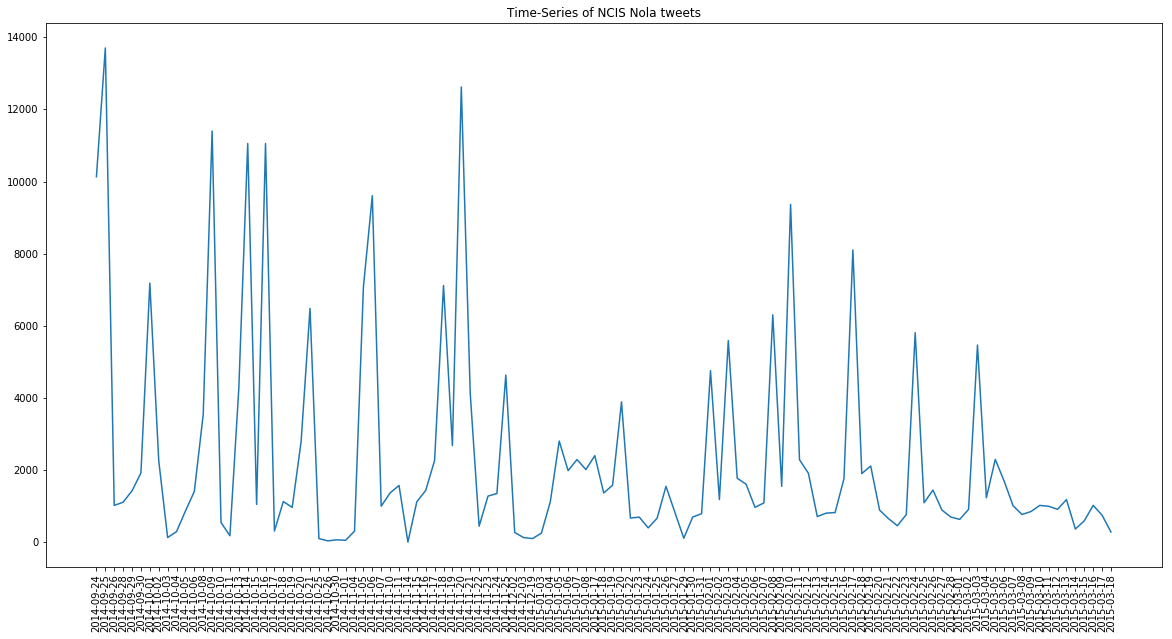

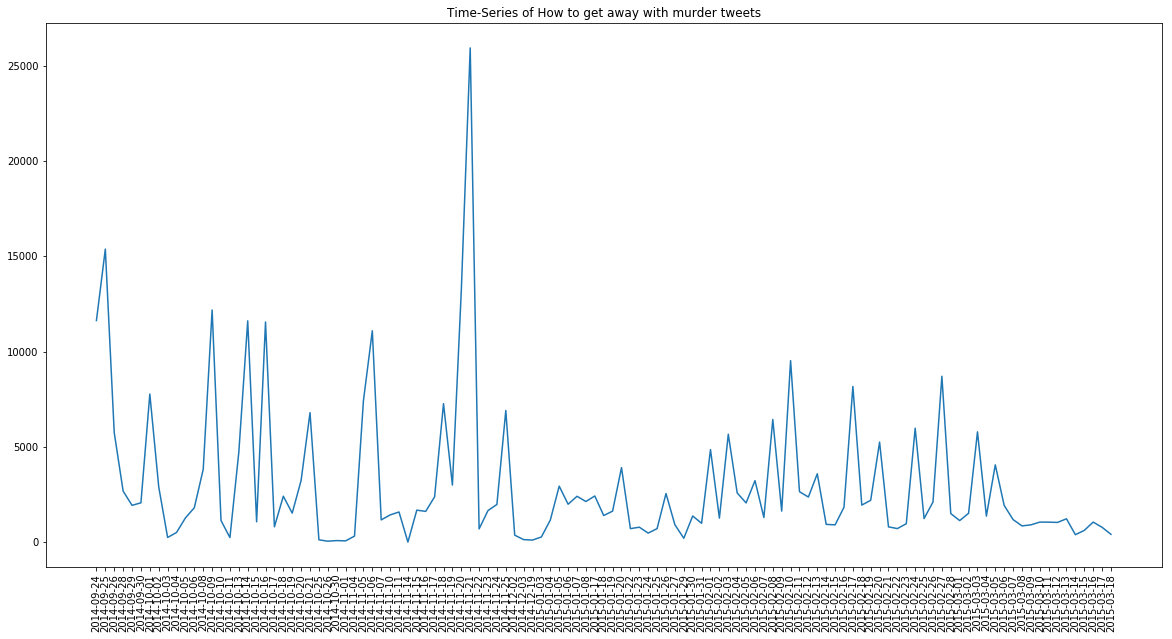

In [18]:
regex = re.compile('.*RT.*', re.IGNORECASE)
date_data = {}
i = 1
for source in data_source:
    for record in source.find({'text' : regex}):
    
        tweet = str(record['text'])
        tweet_words = tweet.split(" ")
        if "RT" in tweet_words[0]:
            timestamp = int(record['timestamp_ms'])/1000
            date_time = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
            date = date_time.split(" ")[0]
            if date in date_data:
                date_data[date] += 1
            else:
                date_data[date] = 1
            
    x_axis = date_data.keys()
    y_axis = date_data.values()
    plt.figure(1, figsize=(20, 10))
    plt.plot(x_axis, y_axis)
    if i == 1:
        plt.title("Time-Series of Gotham tweets")
    elif i == 2:
        plt.title("Time-Series of Blackish tweets")
    elif i == 3:
        plt.title("Time-Series of Selfie tweets")
    elif i == 4:
        plt.title("Time-Series of Red Band Society tweets")
    elif i == 5:
        plt.title("Time-Series of NCIS Nola tweets")
    elif i == 6:
        plt.title("Time-Series of How to get away with murder tweets")

    plt.xticks(rotation=90)
    
    i += 1
    plt.show()

## Word cloud of all the users

In [19]:
def build_wordcloud(tweet_list, name):
    wordcloud = WordCloud(max_words=200, width=1000, height=600).generate(tweet_list)
    plt.figure( figsize=(15,8), facecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title("Word Cloud of " + str(name))
    plt.show()


## Creating a retweet network for blackish
A retweet network is the network

Word Cloud for gotham show


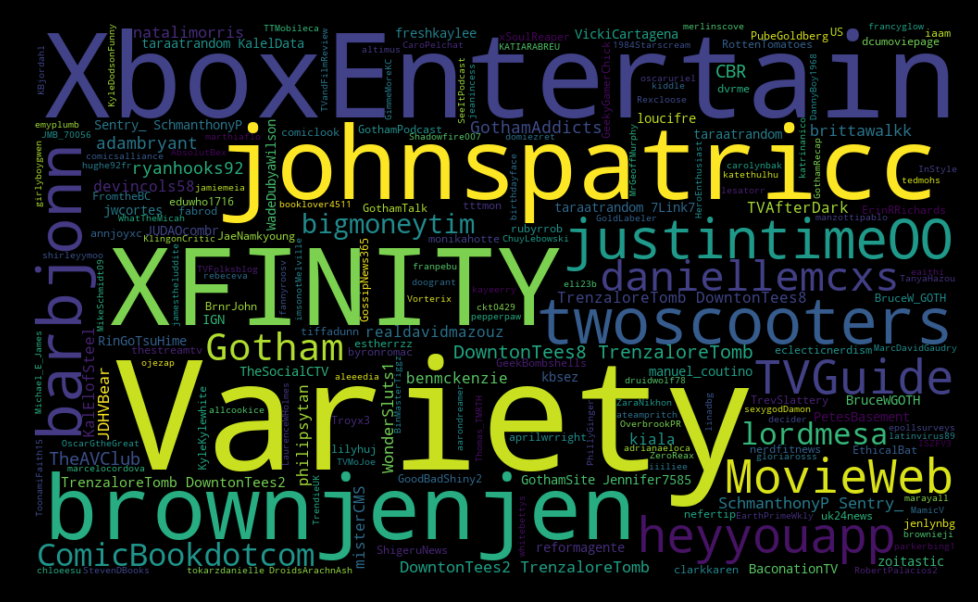

Word Cloud for blackish show


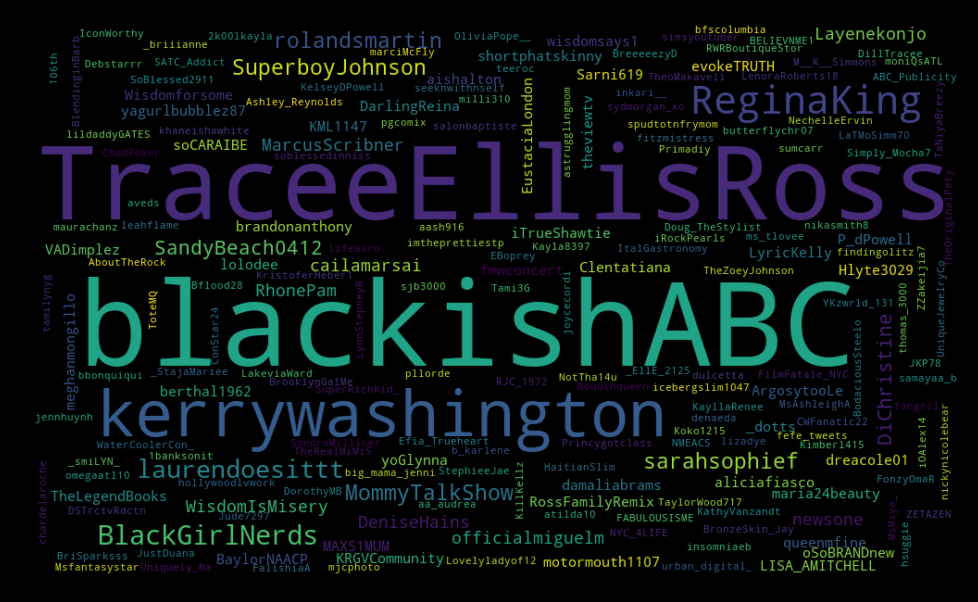

Word Cloud for selfie show


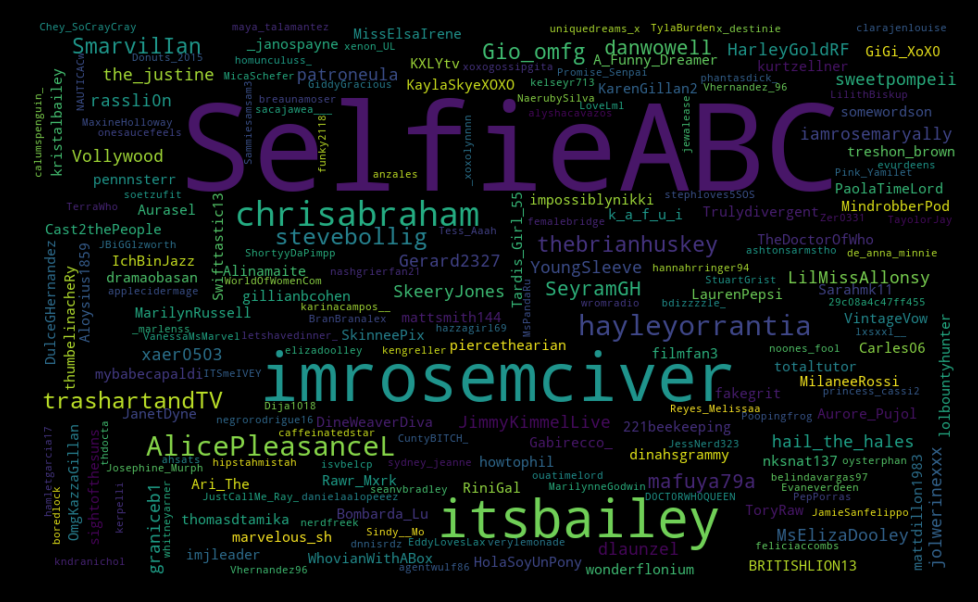

Word Cloud for red_band_society show


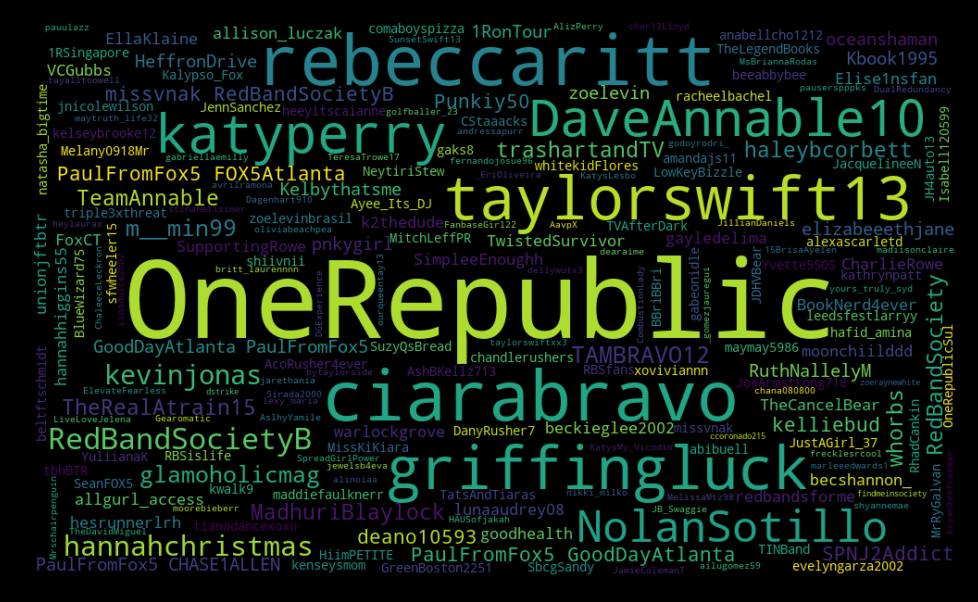

Word Cloud for ncis_nola show


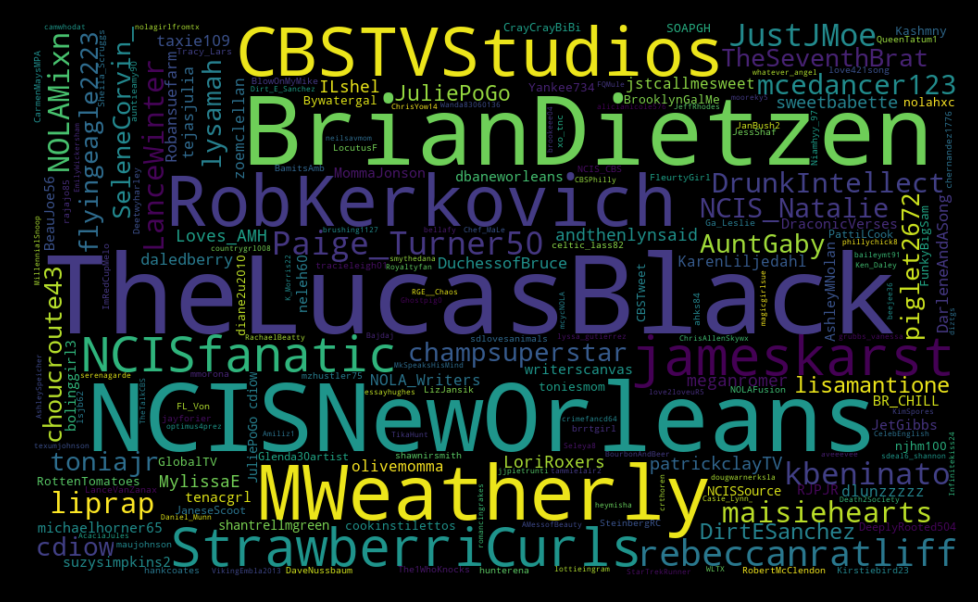

Word Cloud for how_to_get_away show


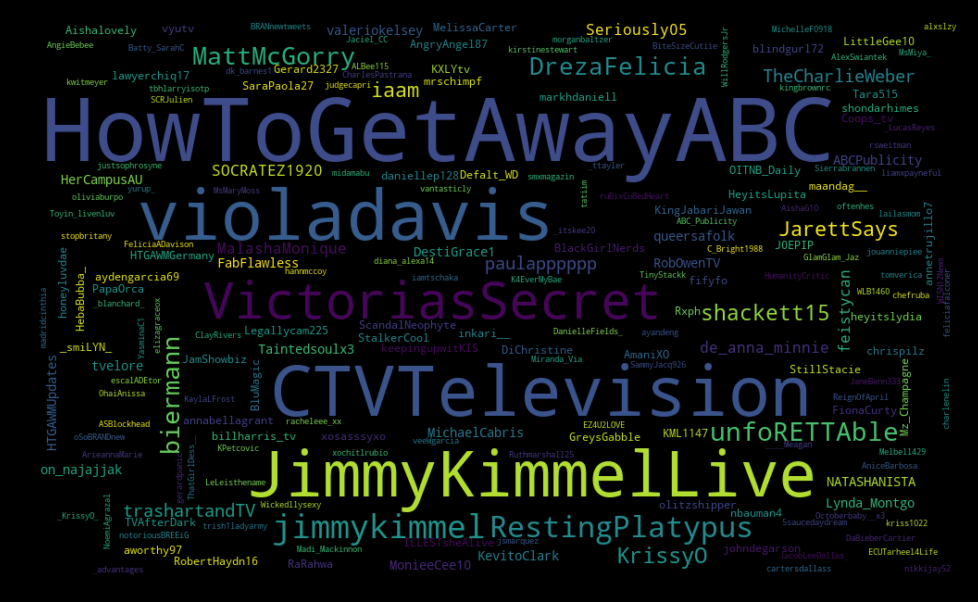

In [20]:
regex = re.compile('.*RT.*', re.IGNORECASE)
j = 0
names = ['gotham', 'blackish', 'selfie', 'red_band_society', 'ncis_nola', 'how_to_get_away']
gotham_dict, blackish_dict, selfie_dict, red_band_society_dict, ncis_nola_dict, how_to_get_away_dict = (defaultdict() 
                                                                                         for i in range(6))
for source in data_source:
    retweet_dict = defaultdict()
    tweet_list = ""
    date_data = {}
    count = 0

    for record in source.find({'text' : regex}).limit(1000):
        count += 1    
        tweet = str(record['text'])
        tweet_words = tweet.split(" ")
    
        if "RT" in tweet_words[0]:
            original_tweet_by = tweet_words[1]
        original_tweet_by = str(''.join(e for e in original_tweet_by if e.isalnum()))
    
        mentions = record['entities']['user_mentions']
        user_name = str(record['user']['screen_name'])
         # Collecting tweets for word cloud#
        tweet_list = tweet_list + original_tweet_by + " " + user_name + " "
        # Time Stamp Dictionary #
        timestamp = int(record['timestamp_ms'])/1000
        date_time = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
        date = date_time.split(" ")[0]
        if date in date_data:
            date_data[date] += 1
        else:
            date_data[date] = 1
     
            # Creating dictionary for who retweeted whom#
        if user_name in retweet_dict:
            check = "False"
            for i in range(len(retweet_dict[user_name])):
                if original_tweet_by in retweet_dict[user_name][i]:
                    retweet_dict[user_name][i][1] += 1
                    check = True
            if check == "False":
                retweet_dict[user_name].append([original_tweet_by, 1]) 
        else:
            retweet_dict[user_name] = []
            retweet_dict[user_name].append([original_tweet_by, 1]) 
    #print(count)
    vertices = retweet_dict.keys()
    edge_nodes = []
    node = {}
    for key, value in retweet_dict.items():
        for i in range(len(key)):
            node[i] = key
        for i in range(len(value)):
            weight_matrix = (key, value[i][0], value[i][1])
            edge_nodes.append(weight_matrix)
    name = names[j]
    print("Word Cloud for " + name + " show")
    build_wordcloud(tweet_list, name)
    j += 1
    if name == 'gotham':
        gotham_dict = retweet_dict
    elif name == 'blackish':
        blackish_dict = retweet_dict
    elif name == 'selfie':
        selfie_dict = retweet_dict
    elif name == 'red_band_society':
        red_band_society_dict = retweet_dict
    elif name == 'ncis_nola':
        ncis_nola_dict = retweet_dict
    elif name == 'how_to_get_away':
        how_to_get_away_dict = retweet_dict

### Different measures for the network graph

#### 1. Network Information


In [21]:
def network_info(network_graph):
    num_nodes = network_graph.number_of_nodes()
    num_edges = network_graph.number_of_edges()
    num_self_loop = network_graph.number_of_selfloops()
    print("Number of self loops: " + str(num_self_loop))
    print(f"There are {network_graph.number_of_nodes()} nodes and {network_graph.number_of_edges()} edges present.")

#### 2. EigenVector Centrality
Measures of one’s connection to those who are highly connected.

In [22]:
def eigen_vector(network_graph):
    dict_eigenvector_centrality = nx.eigenvector_centrality_numpy(network_graph)
    sorted_out_eigenvector = sorted(dict_eigenvector_centrality.items(), key=itemgetter(1), reverse=True)
    print("Eigen vector centrality of top 20 nodes:")
    for d in sorted_out_eigenvector[:20]:
        print(d)

#### 2. Closeness

In [23]:
def closeness(network_graph):
    dict_closeness_centrality = nx.closeness_centrality(network_graph)
    sorted_out_closeness = sorted(dict_closeness_centrality.items(), key=itemgetter(1), reverse=True)
    print("closeness of top 20 nodes:")

    for d in sorted_out_closeness[:20]:
        print(d)

#### 3. In-degree and Out-degree Measures
Degree is a measure of number of connections.

In [34]:
def in_degree(network_graph):
    density = nx.density(network_graph)
    print("Network density of network:", density)
    #print("Information: ", nx.info(g_blackish))

    dict_degree_centrality = nx.degree_centrality(network_graph)
    print("Degree centrallity of top 20 nodes:")
    sorted_out_degree = sorted(dict_degree_centrality.items(), key=itemgetter(1), reverse=True)
    for d in sorted_out_degree[:20]:
        print(d)


    out_deg_blackish = network_graph.out_degree(network_graph.nodes())
    nx.set_node_attributes(network_graph, out_deg_blackish, 'out_degree')
    sorted_out_degree = sorted(out_deg_blackish, key=lambda tup:tup[1], reverse=True)
    print("Out degree centrality of top 20 nodes:")
    for d in sorted_out_degree[:20]:
        print(d)

    in_deg_blackish = network_graph.in_degree(network_graph.nodes())
    nx.set_node_attributes(network_graph, in_deg_blackish, 'in_degree')
    sorted_in_degree = sorted(in_deg_blackish, key=lambda tup:tup[1], reverse=True)
    print("In degree centrality of top 20 nodes:")
    for d in sorted_in_degree[:20]:
        print(d)

#### 4. Betweenness Centrality
Compute the shortest-path betweenness centrality for nodes.

In [25]:
def between(network_graph):
    between_cent_blackish = nx.betweenness_centrality(network_graph)
    print("Between-ness centrallity of top 20 nodes in Blackish:")
    sorted_betweenness = sorted(between_cent_blackish.items(), key=itemgetter(1), reverse=True)
    for d in sorted_betweenness[:20]:
        print(d)

## Network graph for Gotham

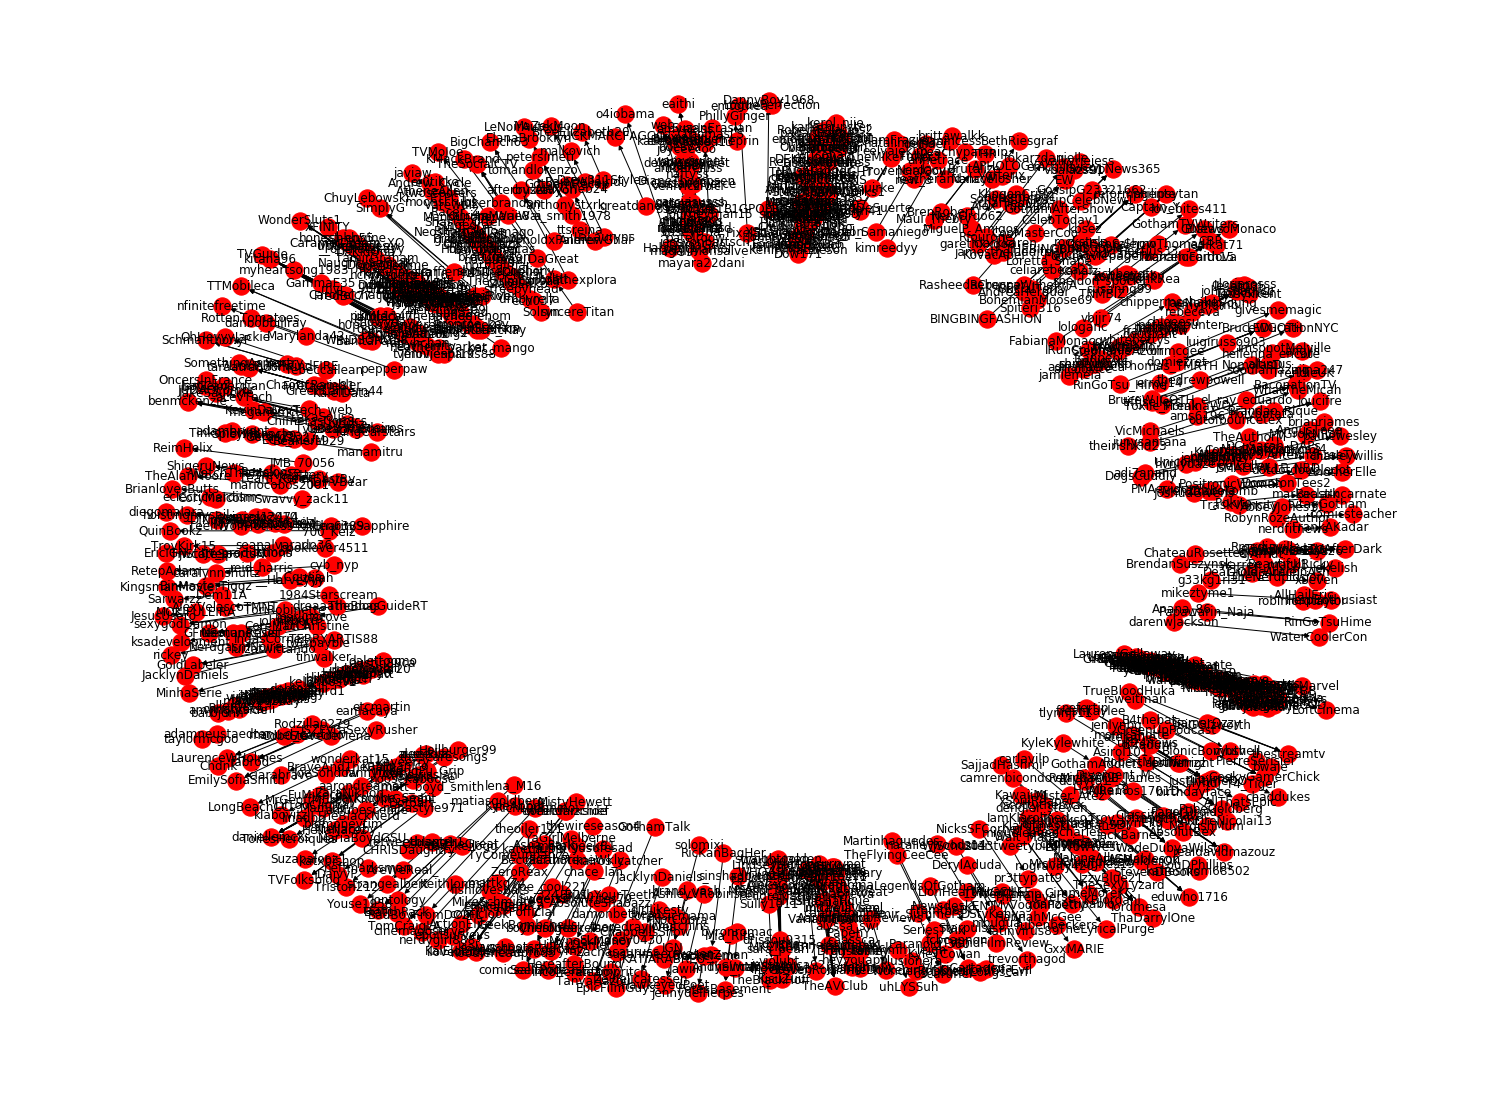

Number of self loops: 0
There are 1083 nodes and 838 edges present.
Eigen vector centrality of top 20 nodes:
('comicsalliance', 0.9436109992016415)
('lordmesa', 0.33105631056005086)
('GothamPodcast', 1.3497873771378837e-05)
('decider', 1.0184947260910405e-05)
('TheSocialCTV', 8.608304513907977e-06)
('emcgillivray', 6.034073248036968e-06)
('ryanhooks92', 4.735652052367772e-06)
('US', 1.8615472021278505e-06)
('GothamTVWriters', 1.7458679243922768e-06)
('TVGuide', 7.566720562393863e-13)
('twoscooters', 4.821534622717447e-13)
('loucifre', 4.026800085052202e-13)
('kiala', 3.4993678528223476e-13)
('GeekBombshells', 3.1675367352175826e-13)
('brownjenjen', 2.983163307950119e-13)
('SeeItPodcast', 2.85464627887479e-13)
('WonderSluts1', 2.7299446441273777e-13)
('ErinRRichards', 2.4364714496642265e-13)
('GimmeMoreKC', 2.2902647756548443e-13)
('RinGoTsuHime', 2.26636841312059e-13)
closeness of top 20 nodes:
('Variety', 0.0711645101663586)
('XboxEntertain', 0.055615364302979836)
('XFINITY', 0.044362

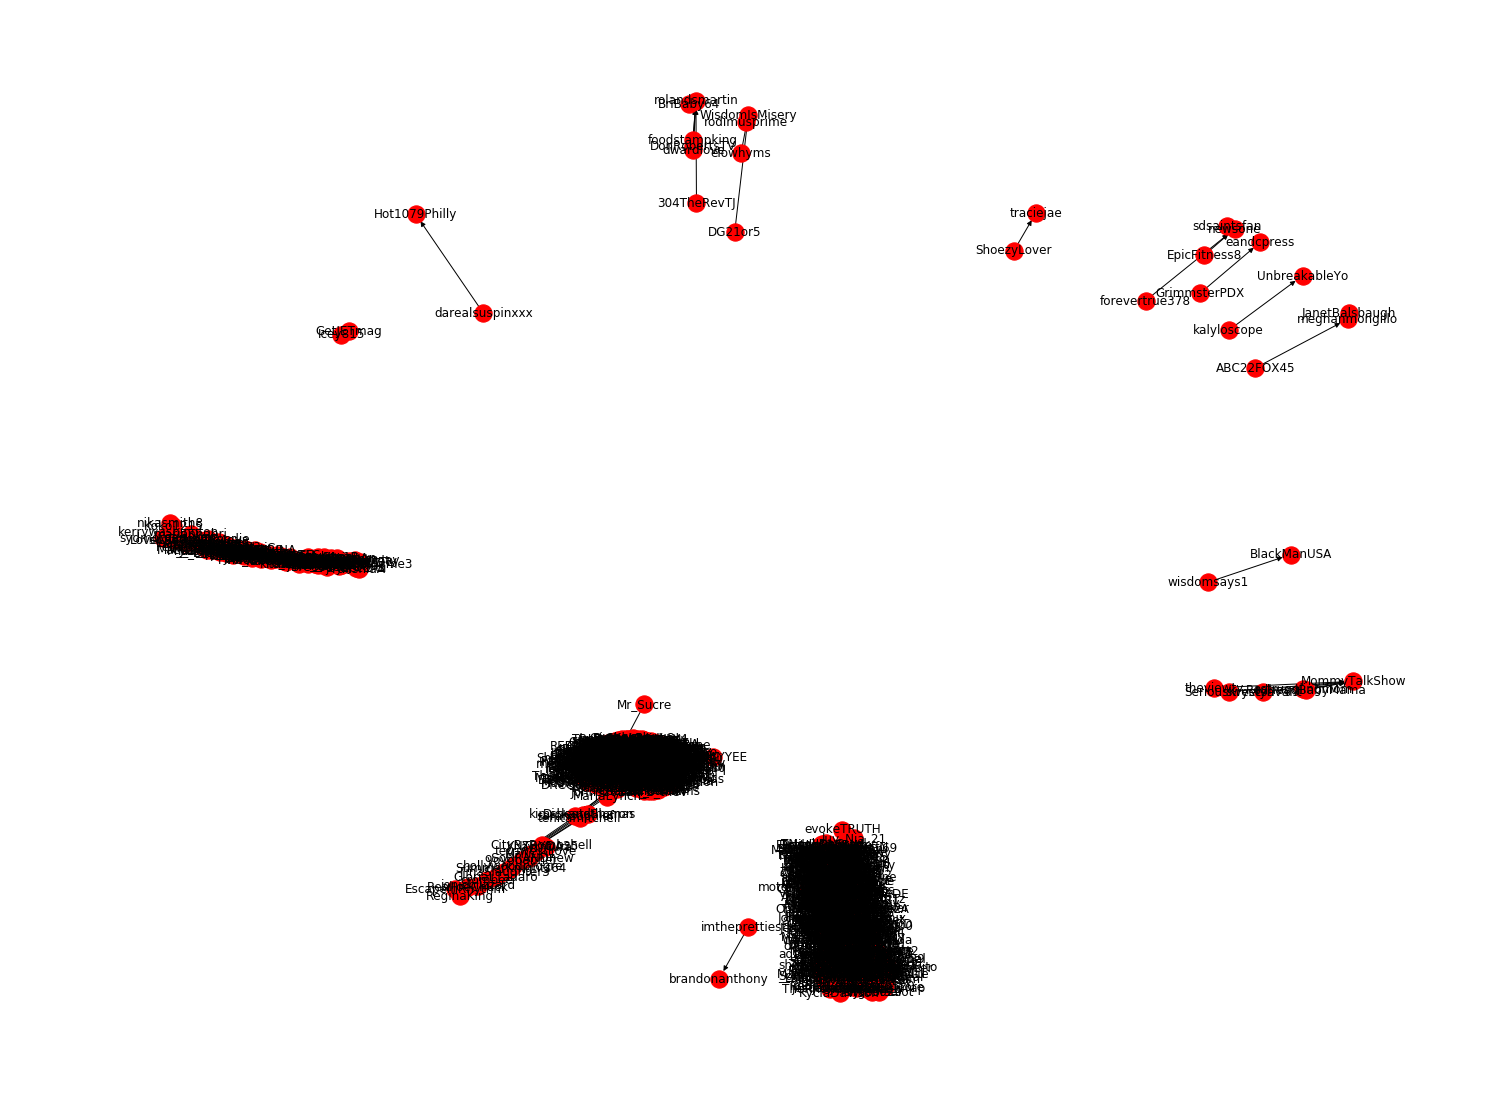

Number of self loops: 0
There are 952 nodes and 937 edges present.
Eigen vector centrality of top 20 nodes:
('ReginaKing', 0.9999999731759648)
('sarahsophief', 0.0002316204499033592)
('blackishABC', 1.8488234364757294e-07)
('TraceeEllisRoss', 5.3648032912110696e-08)
('MarcusScribner', 2.594797170601837e-11)
('BlackGirlNerds', 1.6911189239188423e-11)
('traciejae', 1.4446783476743005e-11)
('UnbreakableYo', 1.4326789014725826e-11)
('GetJETmag', 9.481075768213963e-12)
('EustaciaLondon', 7.907276828376394e-12)
('eandcpress', 6.053823682765027e-12)
('VADimplez', 4.5124543044193e-12)
('RightOnTV', 4.039030439239168e-15)
('MusiqIzMyLyfe21', 4.034423643058389e-15)
('Feathersssss', 4.023452441606239e-15)
('ItAintTazTho', 4.011796671027299e-15)
('JKP78', 4.010820290620588e-15)
('RedheadBabyMama', 4.007822296825159e-15)
('TinyStackk', 4.000412510148108e-15)
('aliciafiasco', 3.997462143806413e-15)
closeness of top 20 nodes:
('blackishABC', 0.43854736909502384)
('TraceeEllisRoss', 0.3943328644476443

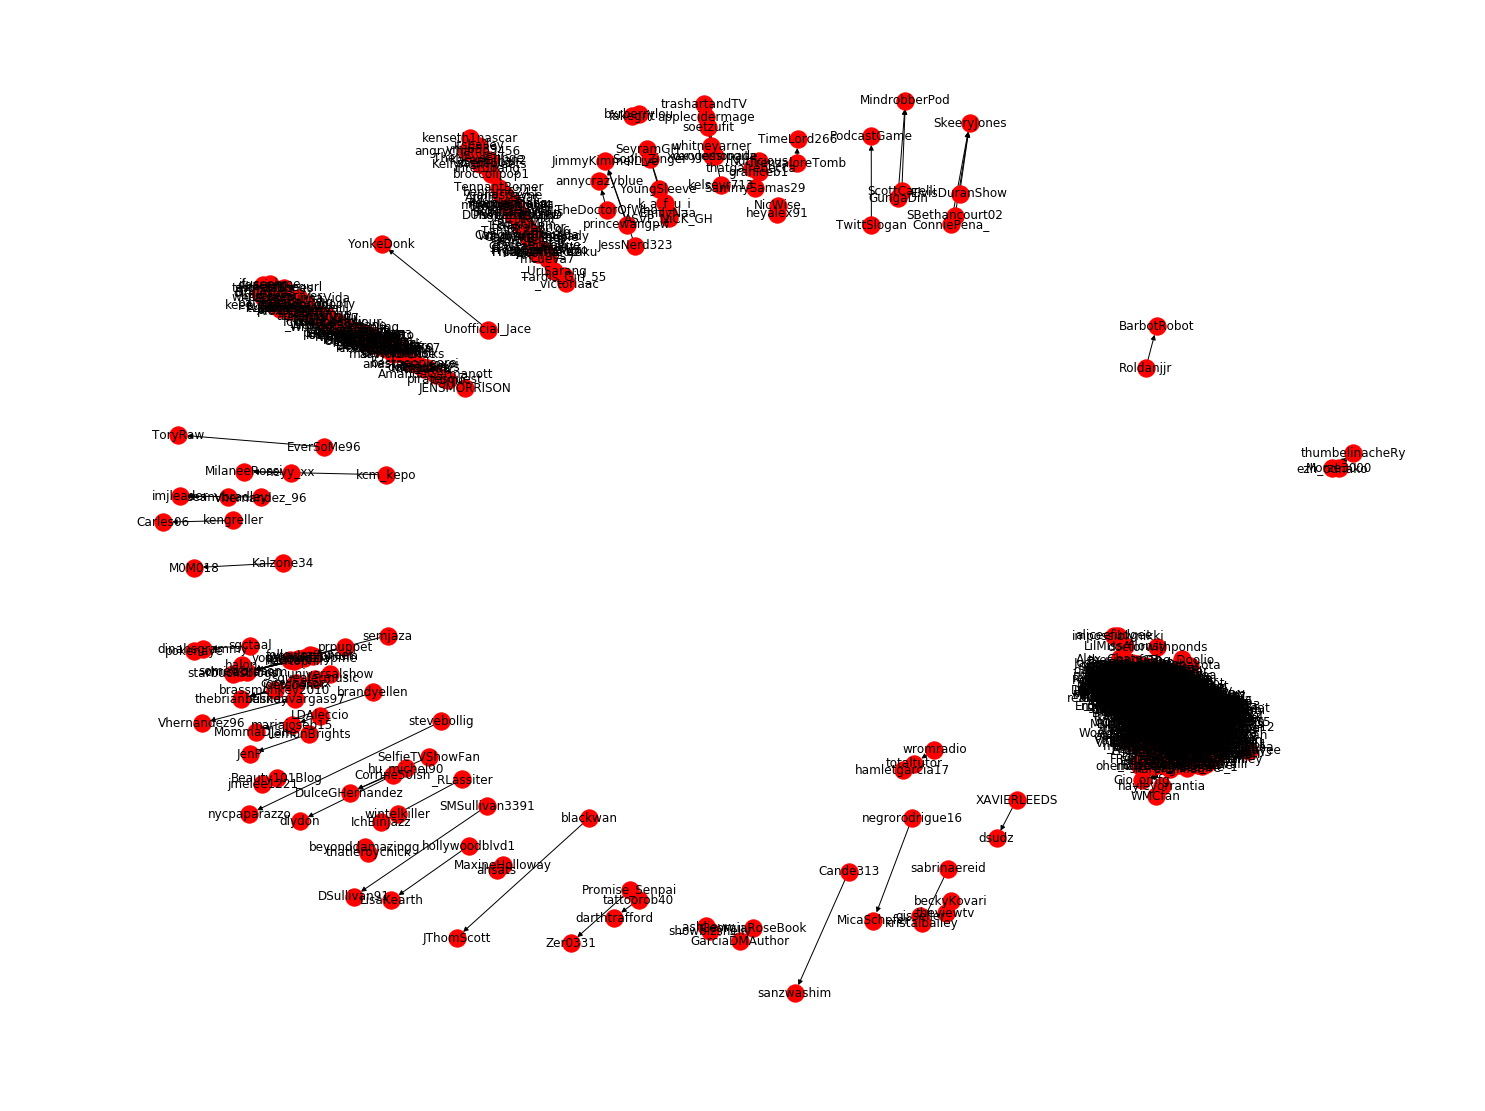

Number of self loops: 0
There are 953 nodes and 904 edges present.
Eigen vector centrality of top 20 nodes:
('hayleyorrantia', 0.9999999989481598)
('SeyramGH', 3.8975552412500494e-05)
('SelfieABC', 2.4178226909328117e-05)
('imrosemciver', 2.6769184544806792e-12)
('chrisabraham', 9.756261900512477e-13)
('Vollywood', 6.314155950991571e-13)
('totaltutor', 5.393515710902662e-13)
('graniceb1', 4.4957139150343417e-13)
('MommaDJane', 4.10964487825024e-13)
('jmelee1221', 4.0318796554225524e-13)
('sanzwashim', 4.01511927070635e-13)
('dinahsgrammy', 3.989016634893846e-13)
('darthtrafford', 3.5029998718499693e-13)
('imjleader', 3.366422988190574e-13)
('DulceGHernandez', 3.3396743950793537e-13)
('dsudz', 2.8884436864630294e-13)
('mafuya79a', 2.5888406739016675e-13)
('trashartandTV', 2.4213877060566026e-13)
('M0M018', 1.520684973853187e-13)
('mariajoseb15', 1.3624917275457532e-13)
closeness of top 20 nodes:
('SelfieABC', 0.7144357743097239)
('hayleyorrantia', 0.36607217994493935)
('imrosemciver', 0

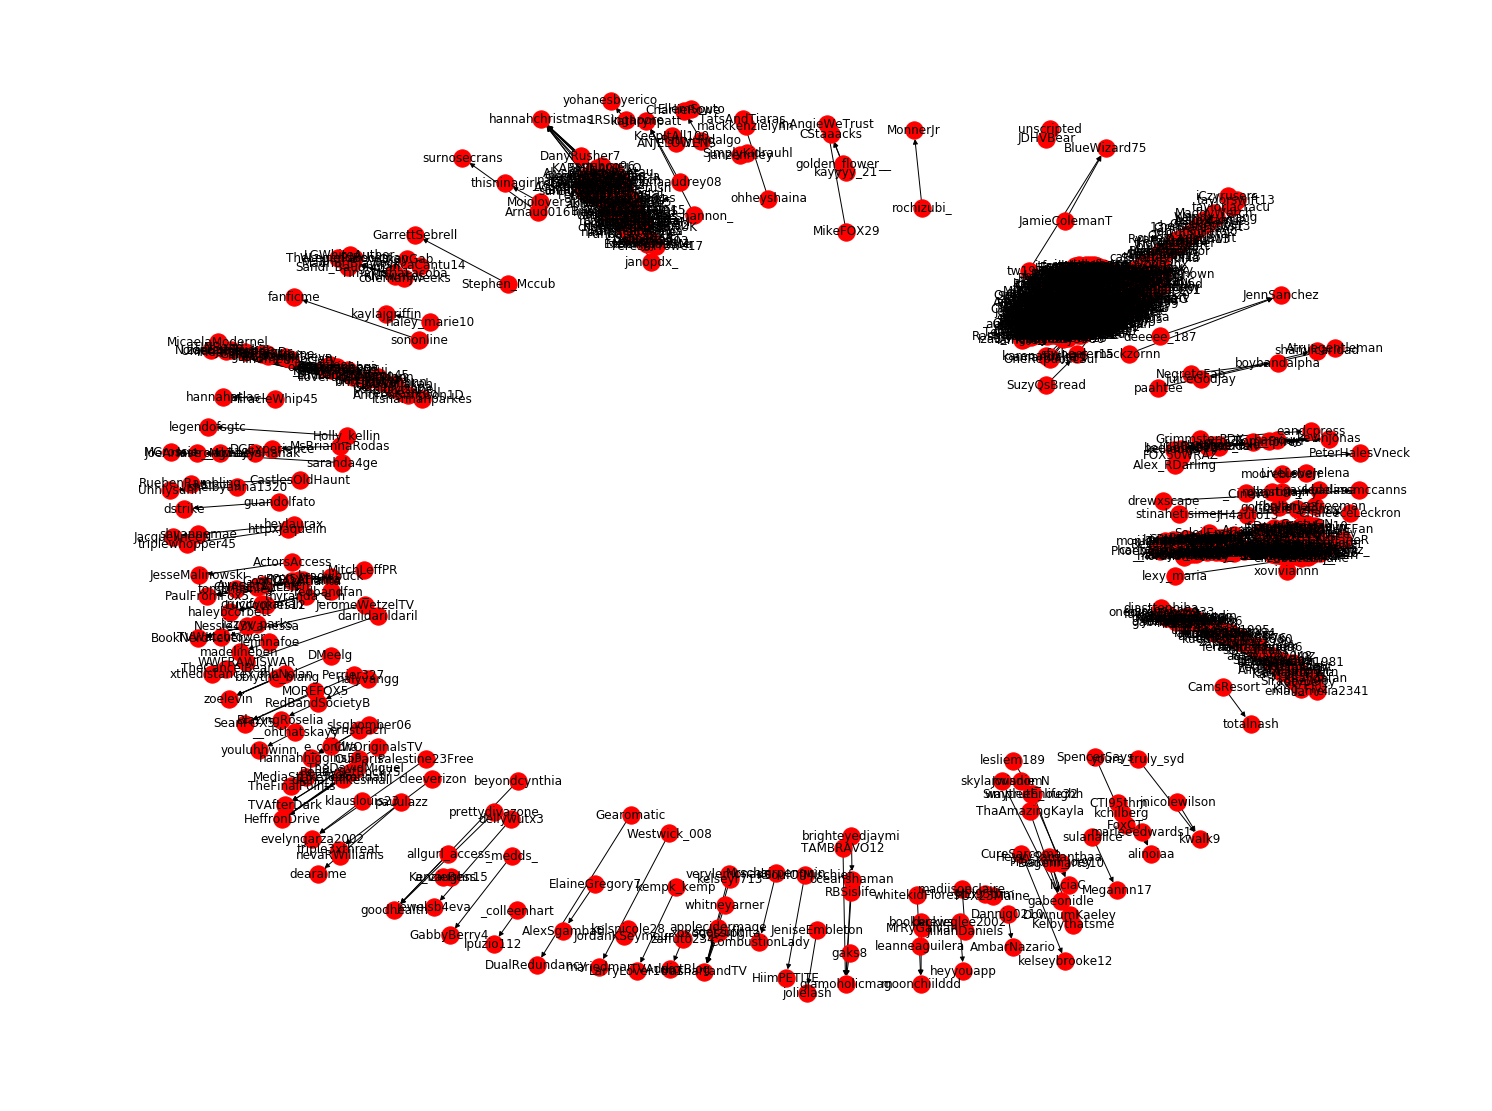

Number of self loops: 0
There are 940 nodes and 842 edges present.
Eigen vector centrality of top 20 nodes:
('taylorswift13', 0.9999998035743235)
('hannahchristmas', 0.0005829104782705017)
('griffingluck', 0.0002062824633821763)
('ciarabravo', 5.6773518892045034e-08)
('OneRepublic', 3.7186078864291917e-08)
('glamoholicmag', 2.358238800834346e-08)
('kevinjonas', 2.1508314489554627e-08)
('kenseysmom', 2.009513842525592e-08)
('luciaC', 2.0060233766930207e-09)
('Kelbythatsme', 1.2238080178362166e-11)
('CStaaacks', 1.1958082222954581e-11)
('kaylajgriffin', 7.931513875905318e-12)
('kelsnicole28', 7.893564701901608e-12)
('TheLegendBooks', 7.648875348476774e-12)
('legendofsgtc', 7.304908121124074e-12)
('hannahhiggins55', 6.920391175949637e-12)
('CharlieRowe', 6.5403108569225745e-12)
('JillianDaniels', 6.5113816142721385e-12)
('GracieDzienny', 6.320000561618321e-12)
('triple3xthreat', 6.075262412764497e-12)
closeness of top 20 nodes:
('OneRepublic', 0.3173904209405302)
('taylorswift13', 0.24243

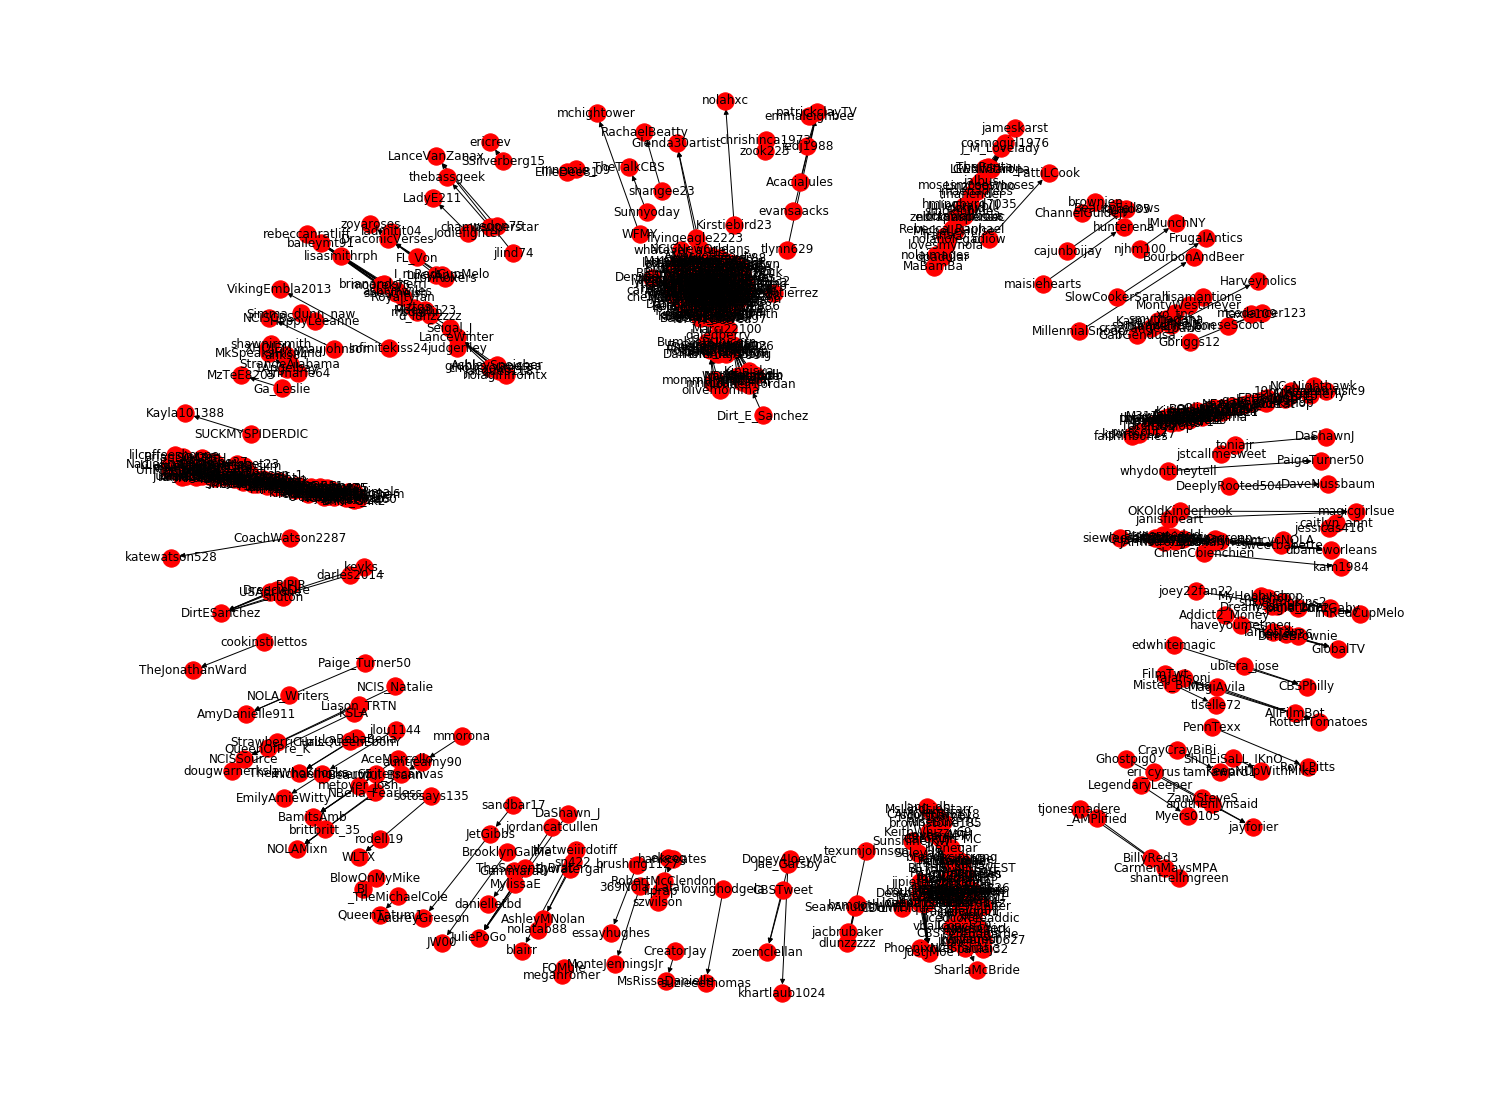

Number of self loops: 0
There are 635 nodes and 549 edges present.
Eigen vector centrality of top 20 nodes:
('RobertMcClendon', 0.7071067811865476)
('liprap', 0.7071067811865475)
('Glenda30artist', 4.103509114383143e-16)
('NCISNewOrleans', 3.0303158929840484e-16)
('TheLucasBlack', 2.0012195879342268e-16)
('RobKerkovich', 1.364465228572035e-16)
('MWeatherly', 7.872187891791375e-17)
('sweetbabette', 7.775458209793191e-17)
('NOLAMixn', 6.962228924819536e-17)
('ILshel', 6.683654906880909e-17)
('Thinnant1950', 4.566446041321127e-17)
('shantrellmgreen', 3.9982753034902226e-17)
('rebeccanratliff', 3.8578488918185155e-17)
('teeni2414', 2.7456796812313844e-17)
('EmilyAmieWitty', 2.7214146537750193e-17)
('jessicas416', 2.498659539301699e-17)
('BOILING_SKIES', 2.4933568960630013e-17)
('katewatson528', 2.4469929753789967e-17)
('MillennialSnoop', 2.4464194798227263e-17)
('NOLAFusion', 2.444685859308472e-17)
closeness of top 20 nodes:
('NCISNewOrleans', 0.12510682295348322)
('TheLucasBlack', 0.12007

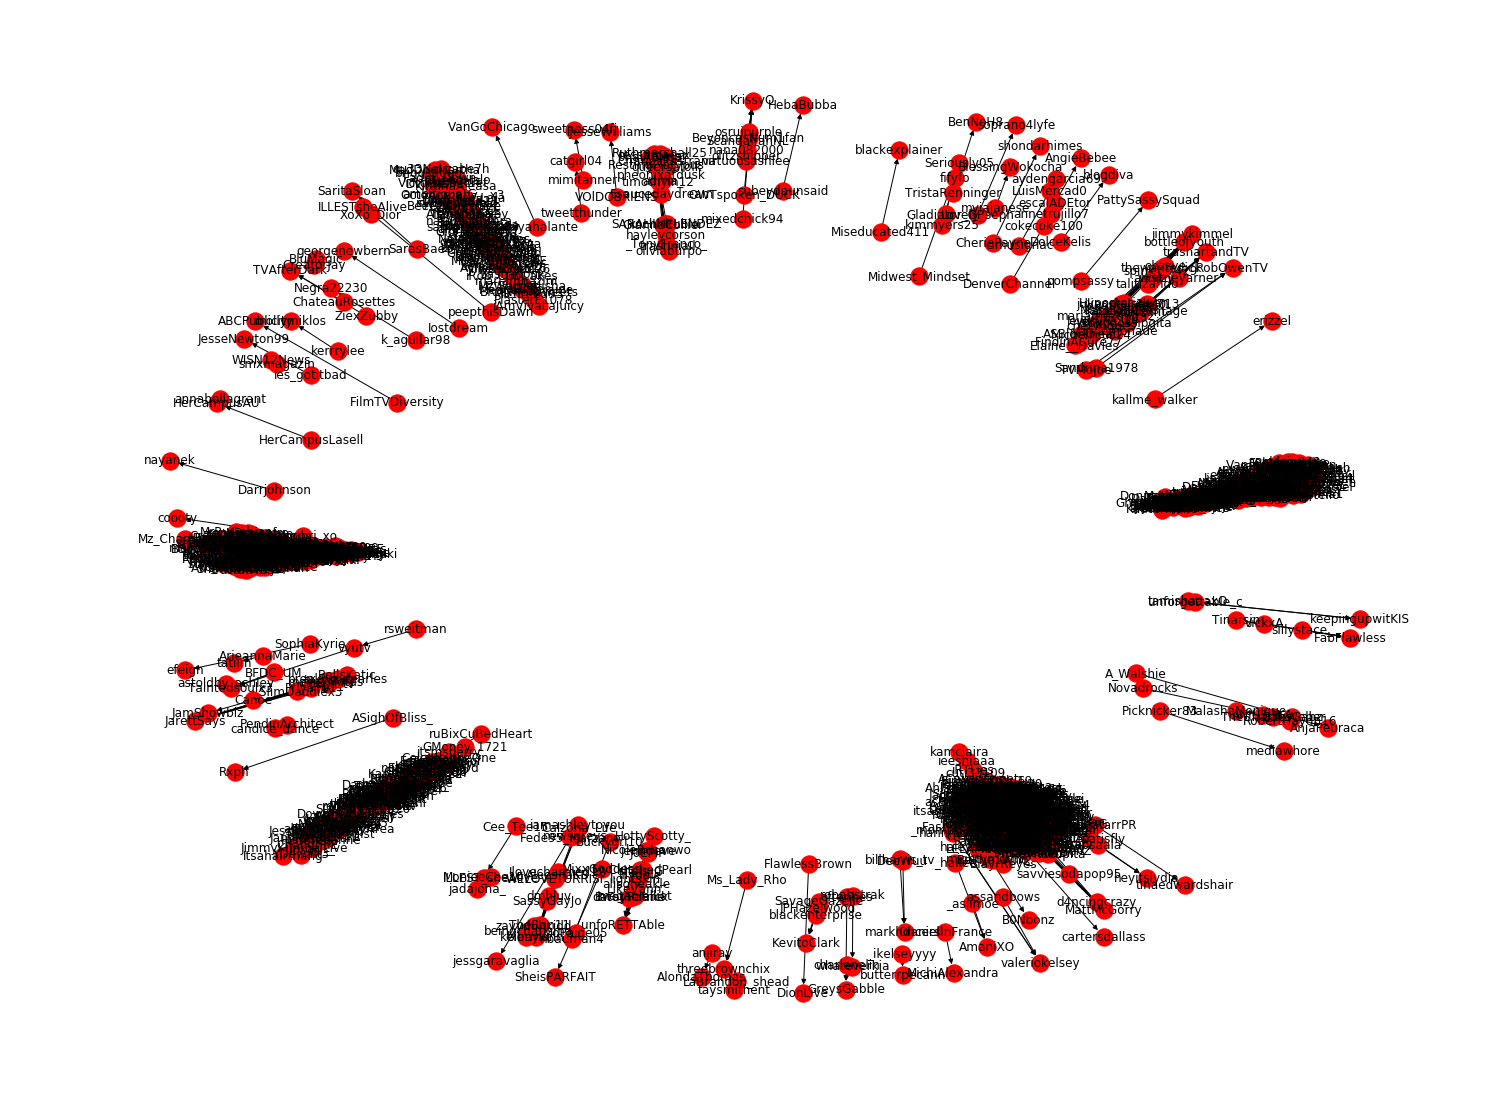

Number of self loops: 0
There are 991 nodes and 917 edges present.
Eigen vector centrality of top 20 nodes:
('MattMcGorry', 0.9999999971189049)
('Taintedsoulx3', 5.0954031236279954e-05)
('shackett15', 3.2818224255704165e-05)
('HowToGetAwayABC', 6.365896499193034e-06)
('JimmyKimmelLive', 3.254168806270836e-06)
('jimmykimmel', 5.478002700385957e-12)
('keepingupwitKIS', 3.8611323291411685e-12)
('TVAfterDark', 2.9077532695979143e-12)
('annetrujillo7', 2.906685624398236e-12)
('violadavis', 2.0085676841780197e-12)
('PendinArchitect', 1.6928364432820644e-12)
('vyutv', 1.6438452484213129e-12)
('SaritaSloan', 1.5720065651438582e-12)
('cartersdallass', 1.517927631267625e-12)
('MonieeCee10', 1.5147195299305936e-12)
('trashartandTV', 1.5084341618857641e-12)
('KevitoClark', 1.4764388604254063e-12)
('sweetness04fj', 1.3907797944528228e-12)
('BluMagic', 1.345659884889203e-12)
('jessgaravaglia', 1.2691996878233999e-12)
closeness of top 20 nodes:
('HowToGetAwayABC', 0.2487947658402204)
('CTVTelevision'

In [36]:
dicts = [gotham_dict, blackish_dict, selfie_dict, red_band_society_dict, ncis_nola_dict, how_to_get_away_dict]
for retweeted_dict in dicts:
        
    graph= nx.DiGraph()
    for key in retweeted_dict:
        user = key
        interactions = retweeted_dict[key]
        #print(interactions)
        for i in range(len(interactions)):
            retweeted = interactions[i][0]
            num_times = interactions[i][1]
        graph.add_edge(user, retweeted, weight=num_times)
    nx.draw(graph, with_labels=True)
    fig = plt.gcf()
    fig.set_size_inches(20,15)
    plt.show()    
    network_info(graph) 
    eigen_vector(graph)
    closeness(graph)
    in_degree(graph)
    between(graph)
    
    if retweeted_dict==gotham_dict:
        gotham_graph = graph
    elif retweeted_dict == blackish_dict:
        blackish_graph = graph
    elif retweeted_dict == selfie_dict:
        selfie_graph = graph
    elif retweeted_dict == red_band_society_dict:
        red_band_graph = graph
    elif retweeted_dict == ncis_nola_dict:
        ncis_graph = graph
    elif retweeted_dict == how_to_get_away_dict:
        how_to_graph = graph

## Algorithms

### 1. Louvain Algorithm for Community Detection 

In [39]:
def louvain_community_algo(undirect_gr, dataset):
    partition=community.best_partition(undirect_gr)
    print('Completed Louvain algorithm .. . . ' )
    values=[partition.get(node) for node in undirect_gr.nodes()]
    list_com=partition.values()

    # Creating a dictionary like {community_number:list_of_participants}
    dict_nodes={}

    # Populating the dictionary with items
    for each_item in partition.items():
        community_num=each_item[1]
        community_node=each_item[0]
        if community_num in dict_nodes:
            value=dict_nodes.get(community_num) + ' | ' + str(community_node)
            dict_nodes.update({community_num:value})
        else:
            dict_nodes.update({community_num:community_node})

    # Creating a new graph to represent the communities created by the Louvain algorithm
    mlt.rcParams['figure.figsize']= [12, 8]
    G_comm=nx.Graph()

    # Populating the data from the node dictionary created earlier
    G_comm.add_nodes_from(dict_nodes)

    # Calculating modularity and the total number of communities
    mod=community.modularity(partition,undirect_gr)
    print("Modularity: ", mod)
    print("Total number of Communities=", len(G_comm.nodes()))

    # Creating the Graph and also calculating Modularity
    mlt.rcParams['figure.figsize']= [12, 8]
    pos_louvain=nx.spring_layout(G_comm)
    nx.draw_networkx(G_comm, pos_louvain, with_labels=True,node_size=160,font_size=11,
                     label='Modularity =' + str(round(mod,3)) +
                    ', Communities=' + str(len(G_comm.nodes())))
    title = "Community structure (Louvain Algorithm) for " + dataset  
    plt.suptitle(title,fontsize=22,fontname='Arial')
    plt.box(on=None)
    plt.axis('off')
    plt.legend(bbox_to_anchor=(0,1), loc='best', ncol=1)
    plt.show()

In [40]:
def community_graph(undirect_gr, dataset):
    # Starting with an initial partition of the graph and running the Louvain algorithm for Community Detection

    nx.draw_networkx(undirect_gr, cmap=plt.get_cmap('magma'), node_color=values,node_size=30, with_labels=False)
    title = "Louvian Algorithm Community Structure for " + dataset
    plt.suptitle(title,fontsize=22)
    plt.box(on=None)
    plt.axis('off')
    plt.show()

Completed Louvain algorithm .. . . 
Modularity:  0.9726375824897733
Total number of Communities= 246


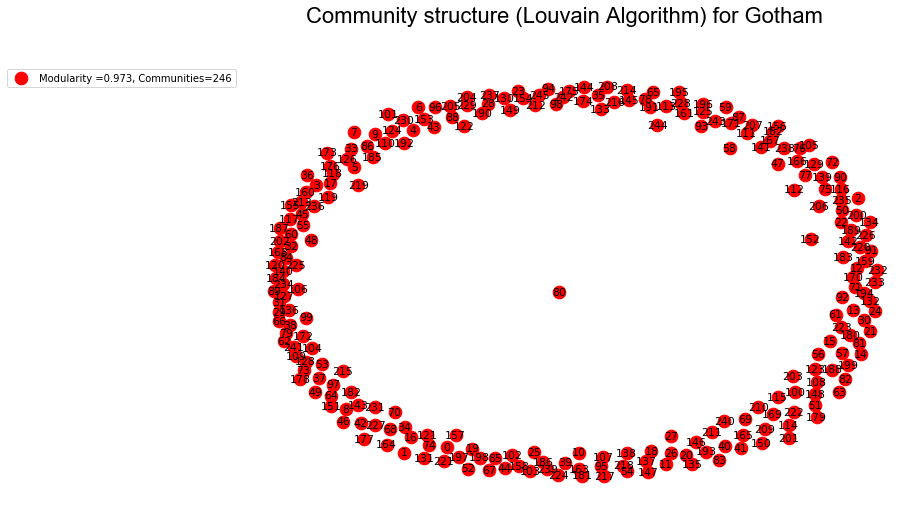

ValueError: 'c' argument has 635 elements, which is not acceptable for use with 'x' with size 1083, 'y' with size 1083.

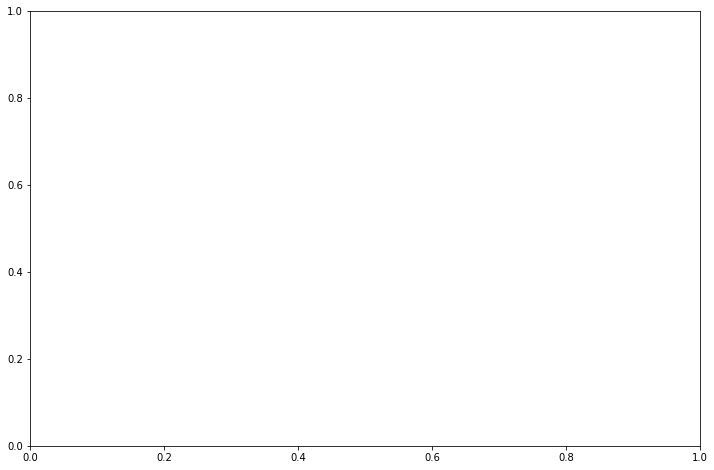

In [41]:
graphs = [gotham_graph, blackish_graph, selfie_graph, red_band_graph, how_to_graph, ncis_graph]
count = 0 
for gr in graphs:
    undirect_gr = gr.to_undirected()
    if count == 0:
        louvain_community_algo(undirect_gr, "Gotham")
        community_graph(undirect_gr, "Gotham")
    elif count == 1:
        louvain_community_algo(undirect_gr, "Blackish")
        community_graph(undirect_gr, "Blackish")
    elif count == 2:
        louvain_community_algo(undirect_gr, "Selfie")
        community_graph(undirect_gr, "Selfie")
    elif count == 3:
        louvain_community_algo(undirect_gr, "Red Band Society")
        community_graph(undirect_gr, "Red Band Society")
    elif count == 4:
        louvain_community_algo(undirect_gr, "How to get away with murder")
        community_graph(undirect_gr, "How to get away with murder")
    elif count == 5:
        louvain_community_algo(undirect_gr, "NCIS Nola")
        community_graph(undirect_gr, "NCIS Nola")

    count += 1
    

### 2. Girvan Newman Algorithm for community detection

In [ ]:
undirect_blackish = g_blackish.to_undirected()
comp=girvan_newman(undirect_blackish)
com=0
thisdict={}

# Populating the items of the dictionary
for c in next(comp):
    list=sorted(c)
    for i in range(len(list)):
        if list[i] in thisdict:
            print('already found')
        else:
            thisdict.update({list[i]: com})
        i+=1
    com+=1

values_girvan=[thisdict.get(node) for node in undirect_blackish.nodes()]
#print(values_girvan)

# Creating a dictionary like 'Community num':'List of participants'
dict_nodes_girvan={}
for each_item in thisdict.items():
    community_num=each_item[1]
    community_node=each_item[0]
    
    if community_num in dict_nodes_girvan:
        value=dict_nodes_girvan.get(community_num) + ' | ' + str(community_node)
        dict_nodes_girvan.update({community_num: value})
    else:
        dict_nodes_girvan.update({community_num: community_node})
        
#Creating a graph where each node represents a community
G_comm_girvan=nx.Graph()
G_comm_girvan.add_nodes_from(dict_nodes_girvan)

# Calculation of number of communities and modularity
print("Total number of Communities=", len(G_comm_girvan.nodes()))
mod_girv=community.modularity(thisdict,undirect_blackish)
print("Modularity:", mod_girv)

# Creation of the graph
pos_girvan=nx.spring_layout(G_comm_girvan)
nx.draw_networkx(G_comm_girvan, pos_girvan,with_labels=True,node_size=160,font_size=11, node_color='yellow',
                 label='Modularity =' + str(round(mod_girv,3)) +', Communities=' + str(len(G_comm_girvan.nodes())))
plt.suptitle('Blackish Community Structure (Girvan-Newman Algorithm)',fontsize=22,fontname='Arial')
plt.box(on=None)
plt.axis('off')
plt.legend(bbox_to_anchor=(0,1), loc='best', ncol=1)
plt.show()

In [ ]:
nx.draw_networkx(undirect_blackish, cmap=plt.get_cmap('magma'), node_color=values,node_size=30, with_labels=False)
plt.suptitle('Girwan Newman Algorithm Community Structure',fontsize=22)
plt.box(on=None)
plt.axis('off')
plt.show()

In [ ]:
#opt_community = nx.
global_modularity_blackish = community.modularity(communities_blackish_bp, undirect_blackish)
#print(global_modularity_blackish)
c = greedy_modularity_communities(undirect_blackish)
#print(c)

a=nx.find_cliques(undirect_blackish)
i=0

# For each clique, print the members and also print the total number of communities
for clique in a:
    print (clique)
    i+=1
total_comm_max_cl=i
print('Total number of communities: ',total_comm_max_cl)

# Remove "len(clique)>1" if you're interested in maxcliques with 2 or more edges
cliques=[clique for clique in nx.find_cliques(undirect_blackish) if len(clique)>1]

## Page Rank Algorithm
#### Page rank calculates the number of links coming in the node. i.e. the user retweeting the most has higher page rank.
*Note : Page rank algorithm is used to rank pages in search engines.

In [ ]:
page_rank_blackish = nx.pagerank(g_blackish, alpha=0.9)
sorted_page_rank_blacish = sorted(page_rank_blackish.items(), key=itemgetter(1), reverse=True)
print("Top 20 nodes by Page Rank:")
for d in sorted_page_rank_blacish[:20]:
    print(d)

In [ ]:
blackish_retweet_dict_time = defaultdict()
tweet_list = ""
regex = re.compile('.*RT.*', re.IGNORECASE)
date_data = {}
count = 0
for record in blackish.find({'text' : regex}):
    count += 1    
    tweet = str(record['text'])
    tweet_words = tweet.split(" ")
    
    if "RT" in tweet_words[0]:
        original_tweet_by = tweet_words[1]
    original_tweet_by = str(''.join(e for e in original_tweet_by if e.isalnum()))
    
    mentions = record['entities']['user_mentions']
    user_name = str(record['user']['screen_name'])
         # Collecting tweets for word cloud#
    tweet_list = tweet_list + original_tweet_by + " " + user_name + " "
        # Time Stamp Dictionary #
    timestamp = int(record['timestamp_ms'])/1000
    date_time = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
    date = date_time.split(" ")[0]
    if date in blackish_retweet_dict_time:
     
        if user_name in blackish_retweet_dict_time[date]:
            check = "False"
            for i in range(len(blackish_retweet_dict_time[date][user_name])):
                if original_tweet_by in blackish_retweet_dict_time[date][user_name][i]:
                    blackish_retweet_dict_time[date][user_name][i][1] += 1
                    check = True
            if check == "False":
                blackish_retweet_dict_time[date][user_name].append([original_tweet_by, 1]) 
        else:
            blackish_retweet_dict_time[date][user_name] = []
            blackish_retweet_dict_time[date][user_name].append([original_tweet_by, 1]) 
    else:
        blackish_retweet_dict_time[date] = {}
        blackish_retweet_dict_time[date][user_name] = []
        blackish_retweet_dict_time[date][user_name].append([original_tweet_by, 1])
        
time_period = ['09', '10', '11', '12', '01', '02', '03']   
print(time_period)
